# Twitter Topic Modeling with Non-negative Matrix Factorization.

Modeling topics from real-world Twitter data using matrix factorization techniques, with a specific focus on tweets about the pandemic. The goal is to extract low-dimensional representations of tweets by identifying and weighting topics

In [31]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

In [32]:
text = pd.read_csv('tweets-2020-4-30.csv')
np.random.seed(416)

In [34]:
text = text.fillna('') 
text.tail()

,text
119142,check results sociallydistant airshow weeks sh...
119143,covid sunsets ra sunset rona ronasunsets duskt...
119144,one favorite performances star band lit livemu...
119145,reminder massmedical members weekly member cal...
119146,i’d never thought primark’s origin hq owns sur...


The dataset was pre-processed to improve modeling accuracy. Steps included filtering for English tweets, removing URLs, converting text to lowercase, removing punctuation and stop words, and excluding overly frequent COVID-related terms. These pre-processing steps help to clean the data and make it more suitable for analysis. The original dataset also contained additional columns beyond just text.

In [ ]:
text = data['text'][data['lang']=='en']
text = text.apply(lambda x: re.sub(r"https\S+", "", str(x)))
text = text.str.lower()
text = text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', 
                   '#coronavirusPandemic', '#covid19', '#covid_19', 
                   '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 
                   'covid19','covid-19', 'covidー19'])

def remove_stopwords(tweet):
    words = tweet.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words) 

text = text.apply(remove_stopwords)

To apply matrix factorization methods, the text data was converted into a numeric representation using Term Frequency-Inverse Document Frequency (TF-IDF). This technique creates a word weight vector for each document, giving more importance to significant words while downweighting common ones. The extraction was done using scikit-learn.

In [35]:
vectorizer = TfidfVectorizer(max_df=0.95) 
tf_idf = vectorizer.fit_transform(text['text'])
feature_names = vectorizer.get_feature_names_out()
tf_idf.shape

(119147, 183012)

In [36]:

num_tweets = len(text)
num_words = len(feature_names)
num_tweets
num_words

183012

Utilized Non-negative Matrix Factorization (NMF) to extract topics from the tweet data. A model with 5 components was set up using `sklearn`, with hyperparameters `init='nndsvd'` and `n_components=5`. The NMF model was fit to the TF-IDF matrix (with shape `(num_tweets, num_words)`), resulting in a matrix of "Tweet factors" saved as `tweets_projected`, and the model itself stored in the variable `nmf`. This approach helps identify semantically meaningful topics within the tweets.

In [50]:
nmf = NMF(n_components=5, init='nndsvd')
tweets_projected = nmf.fit_transform(tf_idf)
tweets_projected

array([[0.02219222, 0.00418025, 0.        , 0.00253512, 0.01602228],
       [0.01767937, 0.00028894, 0.00966139, 0.00044591, 0.01479257],
       [0.        , 0.        , 0.        , 0.        , 0.00571455],
       ...,
       [0.00508782, 0.        , 0.        , 0.        , 0.        ],
       [0.00128768, 0.0024476 , 0.        , 0.00087765, 0.00996955],
       [0.00319982, 0.        , 0.        , 0.00019036, 0.00348026]])

Identify the most significant words for each topic by examining their weights in the NMF model. For a small example, use argsort() to sort words by their weights. Given variables small_words and small_weights, you need to create a list sorted_small_words with words ordered from largest to smallest weight. This step helps in identifying the key terms associated with each topic.

In [39]:
small_words = ['dogs', 'cats', 'axolotl']
small_weights = np.array([1, 4, 2])

sorted_w = np.argsort(small_weights)
sorted_w = sorted_w[::-1]
sorted_small_words = [small_words[i] for i in sorted_w]
sorted_small_words

['cats', 'axolotl', 'dogs']

In [40]:
def words_from_topic(topic, feature_names):
  """
  Sorts the words by their weight in the given topic from largest to smallest.
  topic and feature_names should have the same number of entries.

  Args:
  - topic (np.array): A numpy array with one entry per word that shows the weight in this topic.
  - feature_names (list): A list of words that each entry in topic corresponds to

  Returns:
  - A list of words in feature_names sorted by weight in topic from largest to smallest. 
  """
  sorted_w = np.argsort(topic)
  sorted_w = sorted_w[::-1]
  sorted_words = [feature_names[i] for i in sorted_w]
  return sorted_words

In [41]:
def print_top_words(components, feature_names, n_top_words):
    """ 
    print_top_words prints the first n_top_words for each topic in components
    """
    for topic_index, topic in enumerate(components):
        ordered_words = words_from_topic(topic, feature_names)
        top_words = ', '.join(ordered_words[:n_top_words])
        print(f'Topic: #{topic_index}: {top_words}')

print_top_words(nmf.components_, feature_names, 10)

Topic: #0: people, lockdown, get, home, stay, like, one, time, know, go
Topic: #1: cases, new, deaths, total, confirmed, reported, number, positive, reports, today
Topic: #2: spread, app, help, selfreporting, symptoms, download, sooner, identify, slow, daily
Topic: #3: us, china, join, trump, let, million, drug, manmade, intelligence, says
Topic: #4: pandemic, health, support, help, crisis, workers, global, news, need, read


Prints the text of the original tweet and then the value of the tweet after being transformed by NMF.

In [42]:
index = 40151
print(text.iloc[index]['text'])
print(tweets_projected[index])

attention seattle shoppers grocery stores working hard keep employees customers safe part help slow spread ☑️ limit trips ☑️ respect special shopping hours ☑️ follow socialdistance guidance stores wegotthisseattle
[0.00822911 0.         0.02897631 0.         0.01525021]


To determine which topic has the most tweets strongly associated with it:
For each tweet, find the index of the topic with the highest value in the tweets_projected matrix. If there’s a tie, choose the topic with the lowest index.
Count the number of tweets associated with each topic.
Identify the topic index with the highest count of associated tweets.



In [44]:
topics = {
    0:0,
    1:0,
    2:0,
    3:0,
    4:0}
print(tweets_projected)
for index, val in enumerate(tweets_projected):
    max_index = np.argmax(tweets_projected[index])
    topics[max_index] += 1
largest_topic = max(topics, key = topics.get)

[[0.02216523 0.00418058 0.         0.00253153 0.01598377]
 [0.01765826 0.00028899 0.00965633 0.00044535 0.01475628]
 [0.         0.         0.         0.         0.00570078]
 ...
 [0.00508162 0.         0.         0.         0.        ]
 [0.00128623 0.00244778 0.         0.0008764  0.00994545]
 [0.00319597 0.         0.         0.00019009 0.00347184]]


To create a more manageable visualization of the tweets:

1. **Set up a new NMF model** with 3 components instead of 5, using the same hyperparameters as before (`init='nndsvd'`).
2. **Fit the model** to the TF-IDF data and transform it to get the projected tweets.
3. Save the new model in a variable called `nmf_small` and the projected tweets in a variable called `tweets_projected_small`.

This reduction in dimensions will help visualize tweet groupings more easily.

In [45]:
nmf_small = NMF(n_components=3, init='nndsvd')
tweets_projected_small = nmf_small.fit_transform(tf_idf)

In [46]:
print_top_words(nmf_small.components_, feature_names, 10)

Topic: #0: us, people, pandemic, lockdown, need, get, health, time, home, like
Topic: #1: cases, new, deaths, total, confirmed, reported, number, positive, reports, today
Topic: #2: help, spread, app, selfreporting, symptoms, download, sooner, identify, slow, feel


With 3 components in the NMF model, each tweet is represented by 3 values. These values are used as x, y, and z coordinates to create a 3D plot, which visualizes the relationships and groupings of tweets in topic space. This visualization helps to understand how tweets cluster based on their topic associations.

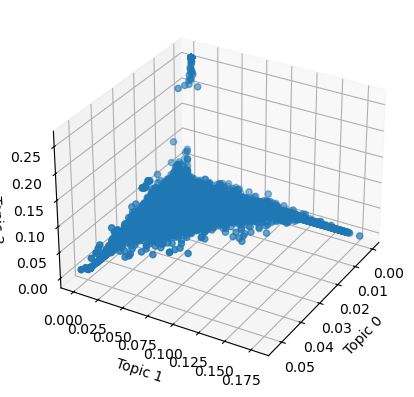

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(tweets_projected_small[:, 0], tweets_projected_small[:, 1], tweets_projected_small[:, 2])

ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')

ax.view_init(30, 30)

To identify outlier tweets, tweets that had a Topic 2 value of 0.15 or higher in the tweets_projected_small matrix were isolated. The corresponding text was recieved from the original DataFrame and used the .unique() function to filter out duplicates. The resulting numpy.array, stored in outlier_tweets, contains all unique tweets that are considered outliers. Analyzing these tweets may reveal a common theme, providing insights into why the model isolated them as a distinct topic.

In [51]:
outliers = []
for index, val in enumerate(tweets_projected_small):
    tweets = tweets_projected_small[index]
    if tweets[2] > 0.15:
        outliers.append(index)
outlier_vals = text.iloc[outliers]
outlier_tweets = outlier_vals['text'].unique()
outlier_tweets

array(['help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app',
       'help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app every little helps',
       'government fails get act together get app help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app',
       'help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app let’s every little helps',
       'help slow spread identify risk cases sooner selfreporting symptoms daily even feel well download app',
       'chance research useful findings already 💪🏼🦠help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app',
       'join millions helping scientists understand spread help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app',
       'youre please consider h